In [1]:
!git clone https://github.com/jsaj/Multi_DES.git

Cloning into 'Multi_DES'...
remote: Enumerating objects: 1039, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 1039 (delta 100), reused 40 (delta 40), pack-reused 901
Receiving objects: 100% (1039/1039), 6.87 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (496/496), done.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from glob import glob
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from yellowbrick.model_selection import FeatureImportances

In [5]:
# dataset/project information

df_info = []
for data in ['AEEEM', 'NASA', 'PROMISE', 'RELINK']:
  for project_url in glob('/content/Multi_DES/benchmark-execution/benchmarks/datasets/{}/*'.format(data)):
    project_name = project_url.split('/')[len(project_url.split('/'))-1].split('.csv')[0]
    df_project = pd.read_csv(project_url)
    df_project = df_project.select_dtypes(exclude=['object'])
    instances = len(df_project)
    features = len(list(df_project.columns))

    y = df_project[df_project.columns[0]]
    bugs = list(np.unique(y))[1:]
    y = y.replace(bugs, 1)
    defective = np.count_nonzero(np.array(y) == 1)
    no_defective = np.count_nonzero(np.array(y) == 0)
    imbalance = 0
    if defective < no_defective:
      imbalance = defective/no_defective
    else:
      imbalance = no_defective/defective

    percent_bugs = round((np.count_nonzero(np.array(y) == 1) / len(y)) * 100, 2)
    
    values = [project_name, instances, features, percent_bugs, int(round(imbalance, 2) *100)] 

    df_info.append(pd.DataFrame([values], columns=['project', 'instances', 'features', 'defects (%)', 'imbalance']))
df_info = pd.concat(df_info)
df_info.head()

,project,instances,features,defects (%),imbalance
0,equinox,324,62,39.81,66
0,pde,1497,62,13.96,16
0,mylyn,1862,62,13.16,15
0,eclipse,997,62,20.66,26
0,lucene,691,62,9.26,10


--------------------------- fscore --------------------------
Feature: defects (%), Score: 0.751
Feature: instances, Score: 0.249
Feature: imbalance, Score: 0.0
Feature: features, Score: 0.0



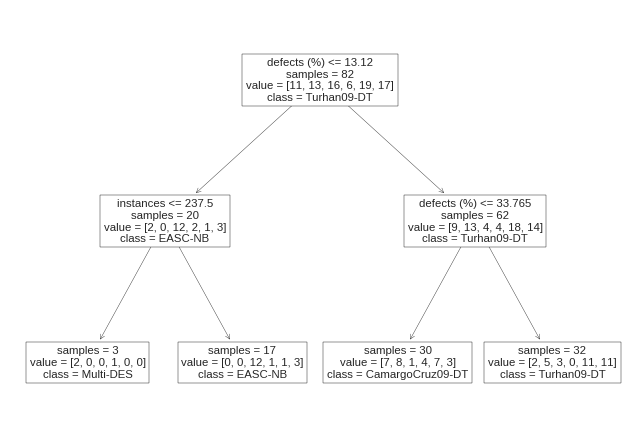

--------------------------- auc --------------------------
Feature: features, Score: 1.0
Feature: instances, Score: 0.0
Feature: imbalance, Score: 0.0
Feature: defects (%), Score: 0.0



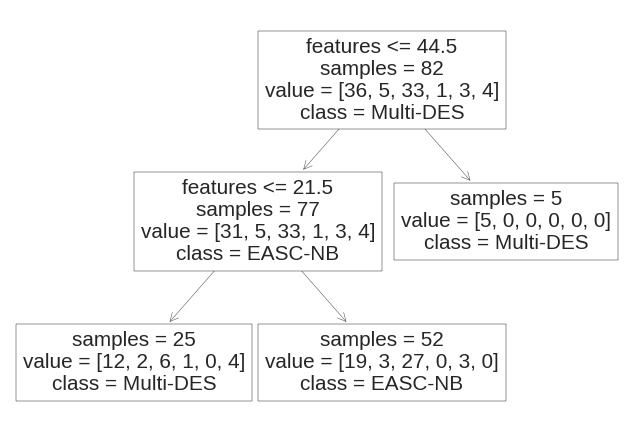

--------------------------- pf --------------------------
Feature: instances, Score: 0.825
Feature: imbalance, Score: 0.175
Feature: features, Score: 0.0
Feature: defects (%), Score: 0.0



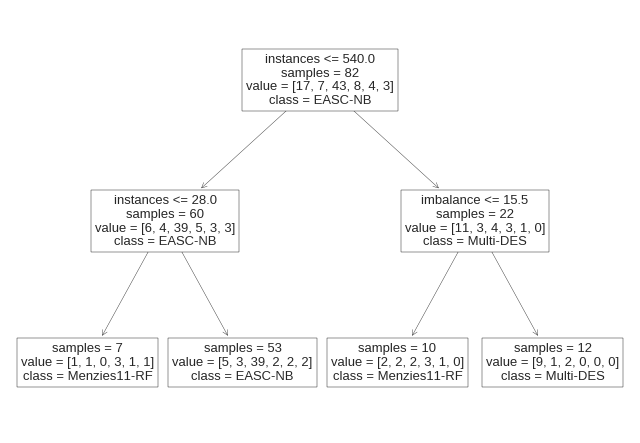

In [8]:
df = pd.read_csv('/content/Multi_DES/benchmark-execution/benchmarks/CPDP_results.csv')
for metric in ['fscore', 'auc', 'pf']:
  print('--------------------------- {} --------------------------'.format(metric))
  metric_plot_tree = df_info

  for project in df['ProductName'].drop_duplicates().to_list():
    cpdp_scores = df.loc[(df['ProductName'] == project), ['Method', metric]].transpose().reset_index()
    cpdp_scores = cpdp_scores.iloc[:, [1, 2, 3, 4, 5, 6]]
    cpdp_scores.columns = cpdp_scores[:1].values[0]
    cpdp_scores = cpdp_scores[1:].reset_index(drop=True)
    for col in cpdp_scores.columns:
      cpdp_scores[col] = cpdp_scores[col].astype(float)

    
    if metric != 'pf':
      method_best_value = cpdp_scores.idxmax(axis=1)
      metric_plot_tree.loc[metric_plot_tree['project'] == project, 'label'] = method_best_value
    else:
      
      method_best_value = cpdp_scores.idxmin(axis=1)
      metric_plot_tree.loc[metric_plot_tree['project'] == project, 'label'] = method_best_value

  df_test = metric_plot_tree.drop(['project'], axis=1).reset_index(drop=True)

  df_test = df_test.replace(['Multi-DES', 'CamargoCruz09-DT', 'EASC-NB',
                             'Menzies11-RF', 'Turhan09-DT', 'Watanabe08-DT'],
                            [1, 2, 3, 4, 5, 6])
  
  classifier = DecisionTreeClassifier(max_depth=2)  # limit depth of tree

  X = df_test.drop(['label'], axis=1)
  y = df_test.label

  classifier.fit(X, y)

  # get importance
  importance = classifier.feature_importances_
  
  for importance, name in sorted(zip(classifier.feature_importances_, X.columns), reverse=True)[:5]:
    print('Feature: {}, Score: {}'.format(name, round(importance, 3)))
  print()
  tree.plot_tree(classifier,
                feature_names = X.columns,
                class_names=['Multi-DES', 'CamargoCruz09-DT', 'EASC-NB', 'Menzies11-RF', 'Turhan09-DT', 'Watanabe08-DT'],
                filled=False,
                impurity=False);     
  plt.show()                         